In [176]:
# import packages
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [179]:
# download data

data_dir = "data/mnist"
checkpoint_path = "checkpoint/model.ckpt"

mnist = input_data.read_data_sets(data_dir, one_hot=True)

input_size = mnist.train.images.shape[1]
label_size = mnist.train.labels.shape[1]

image_width = int(np.sqrt(input_size))
image_height = int(np.sqrt(input_size))

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


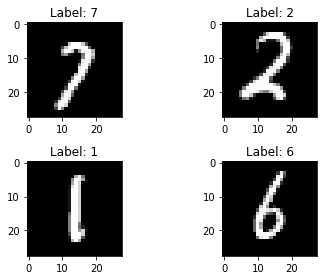

In [198]:
# visualize data
for i in range(4):
    plt.subplot(2, 2, i + 1)
    
    sample_id = np.random.randint(mnist.train.num_examples)
    label = np.argmax(mnist.train.labels[sample_id])
    plt.title("Label: {label}".format(label=label))
    plt.imshow(mnist.train.images[sample_id].reshape(image_width, image_height), cmap='gray')

plt.tight_layout()

In [151]:
def linear_model(x):
    W = tf.get_variable("W", shape=(input_size, label_size))
    b = tf.get_variable("b", shape=(label_size))
    return tf.matmul(x, W) + b

def loss_function(y, logits):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

def optimizer_function(loss, learning_rate):
    return tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

def accuracy_function(y, logits):
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    return tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [152]:
learning_rate = 0.01
n_epochs = 100
batch_size = 100

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(None, input_size))
y = tf.placeholder(tf.float32, shape=(None, label_size))

# define model
logits = linear_model(x)
y_pred = tf.nn.softmax(logits)

# define cost function
loss = loss_function(y, logits)

# define optimizer
optimizer = optimizer_function(loss, learning_rate)

# define initializer
init = tf.global_variables_initializer()

# define accuracy
accuracy = accuracy_function(y, logits)

In [181]:
# train

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    
    for e in range(n_epochs):
        n_batches = int(mnist.train.num_examples / batch_size)
        
        for b in range(n_batches):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            sess.run(optimizer, feed_dict={x:batch_xs, y:batch_ys})
            
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={x:batch_xs, y:batch_ys})
        print("[Epoch {epoch}] loss = {loss}, accuracy = {acc}".format(epoch=e, loss=loss_val, acc=acc_val))
        
    saver.save(sess, checkpoint_path)

[Epoch 0] loss = 0.8540840148925781, accuracy = 0.800000011920929
[Epoch 1] loss = 0.5128029584884644, accuracy = 0.8999999761581421
[Epoch 2] loss = 0.5539636015892029, accuracy = 0.8399999737739563
[Epoch 3] loss = 0.5153911709785461, accuracy = 0.8399999737739563
[Epoch 4] loss = 0.4609004557132721, accuracy = 0.8700000047683716
[Epoch 5] loss = 0.4128696322441101, accuracy = 0.8999999761581421
[Epoch 6] loss = 0.3559877872467041, accuracy = 0.8999999761581421
[Epoch 7] loss = 0.39146843552589417, accuracy = 0.8999999761581421
[Epoch 8] loss = 0.32978734374046326, accuracy = 0.8899999856948853
[Epoch 9] loss = 0.3675276041030884, accuracy = 0.9100000262260437
[Epoch 10] loss = 0.4438638985157013, accuracy = 0.8500000238418579
[Epoch 11] loss = 0.4610399007797241, accuracy = 0.8799999952316284
[Epoch 12] loss = 0.37342551350593567, accuracy = 0.8700000047683716
[Epoch 13] loss = 0.31520870327949524, accuracy = 0.9200000166893005
[Epoch 14] loss = 0.37180137634277344, accuracy = 0.879

INFO:tensorflow:Restoring parameters from checkpoint/model.ckpt
INFO:tensorflow:Restoring parameters from checkpoint/model.ckpt
INFO:tensorflow:Restoring parameters from checkpoint/model.ckpt
INFO:tensorflow:Restoring parameters from checkpoint/model.ckpt


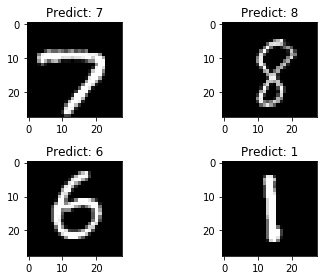

In [196]:
# visualize prediction
def predict_image(image):
    with tf.Session() as sess:
        saver.restore(sess, checkpoint_path)
        return np.argmax(sess.run(y_pred, feed_dict = {x: image.reshape(1, -1)}))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    
    sample_id = np.random.randint(mnist.test.num_examples)
    image_data = mnist.test.images[sample_id]
    prediction = predict_image(image_data)
    plt.title("Predict: {prediction}".format(prediction=prediction))
    plt.imshow(image_data.reshape(image_width, image_height), cmap='gray')

plt.tight_layout()